# Breast cancer case

In [1]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from functions import crossvalidation_as_framework
from seaborn import clustermap

### Load and prep data

In [2]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [3]:
# Define the target variable
target = "vital.status"

In [4]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

### 2 feature models

In [5]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 50,
                                     criterion='bic',
                                     max_complexity = 3)

In [6]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6353392366250381, 0.6308307826966679)

In [7]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(rsCHST9*rsPCK1),647.344838,656.014947,0.665417,0.757092,0.659440,0.730496,0.346362,0.235294,"multiply(""rs_PCK1"", ""rs_CHST9"")"
1,logreg(rsAPOB*rsGPM6A),634.402481,643.072589,0.722427,0.773050,0.588870,0.737589,0.209888,0.232258,"multiply(""rs_GPM6A"", ""rs_APOB"")"
2,logreg(exp(-rsLOC283392**2 - rsOXTR**2)),635.943571,653.283788,0.665003,0.868794,0.537964,0.836879,0.226175,0.236842,"gaussian(""rs_LOC283392"", ""rs_OXTR"")"
3,logreg(exp(-rsMRAP**2 - rsOXTR**2)),660.672829,678.013046,0.629475,0.858156,0.682916,0.879433,0.437718,0.246753,"gaussian(""rs_OXTR"", ""rs_MRAP"")"
4,logreg(rsACVR1C*rsHEPACAM2),667.311813,675.981921,0.731888,0.755319,0.707506,0.758865,0.457274,0.236842,"multiply(""rs_HEPACAM2"", ""rs_ACVR1C"")"


In [8]:
for model in results.groupby("fold").first()['model_structure']:
    print(model)

logreg(rsCHST9*rsPCK1)
logreg(rsAPOB*rsGPM6A)
logreg(exp(-rsLOC283392**2 - rsOXTR**2))
logreg(exp(-rsMRAP**2 - rsOXTR**2))
logreg(rsACVR1C*rsHEPACAM2)


#### Exploration of best models

In [9]:
ql = feyn.connect_qlattice()

In [13]:
best_models_qstrings = results.groupby("fold").first()['query_string'].values

n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        model = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)

**List of inputs**

In [14]:
inputs_list = []
for m in models_trained:
    for i in m.inputs:
        inputs_list.append(i)
        
inputs_list = list(set(inputs_list))

##### **Clustermap**

In [15]:
corr_inputs = data[inputs_list].corr()

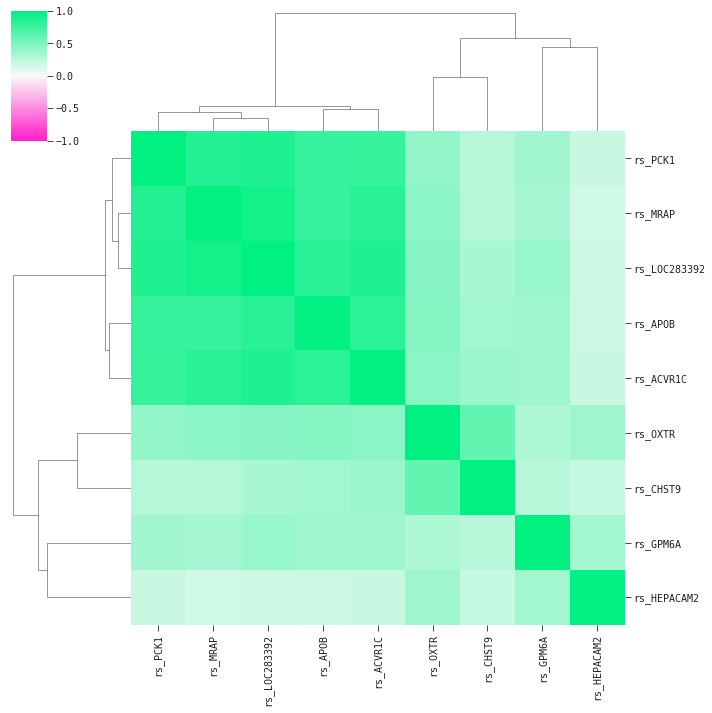

In [16]:
cluster_map_args = {'cmap': 'feyn-diverging', 'vmin': -1, 'vmax': 1}

clustermap(corr_inputs, **cluster_map_args)

In [17]:
data[inputs_list].corr()['rs_APOB'].sort_values(ascending=False)

rs_APOB         1.000000
rs_LOC283392    0.835160
rs_ACVR1C       0.822627
rs_MRAP         0.780383
rs_PCK1         0.773892
rs_OXTR         0.466882
rs_GPM6A        0.372880
rs_CHST9        0.349093
rs_HEPACAM2     0.182369
Name: rs_APOB, dtype: float64

Pairwise Pearson correlation within the main group in the heatmap above varies from ~0.77 to ~0.84

##### **Pearson correlation with output `vital.status`**

In [18]:
pd.DataFrame(data[inputs_list].corrwith(data[target]).abs().sort_values(ascending=False), columns=['Pearson corr.'])

,Pearson corr.
rs_APOB,0.269978
rs_LOC283392,0.230158
rs_PCK1,0.224622
rs_MRAP,0.213739
rs_ACVR1C,0.206477
rs_OXTR,0.194393
rs_CHST9,0.138680
rs_GPM6A,0.116361
rs_HEPACAM2,0.051176


##### **Model response (3 examples)**

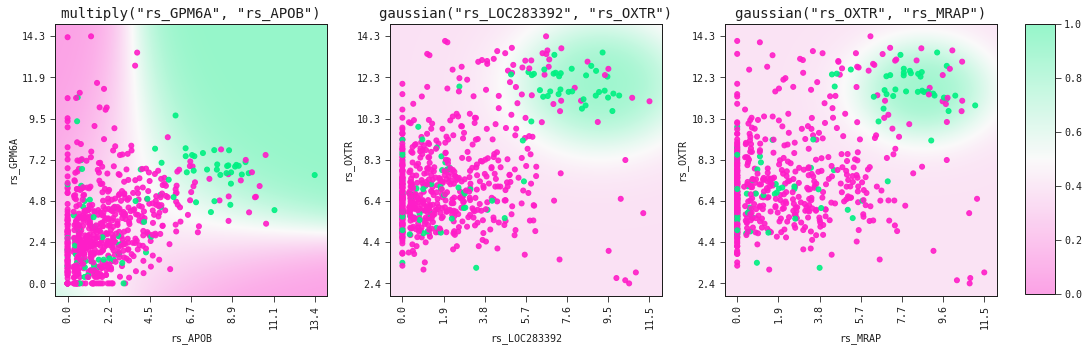

In [19]:
me0, me1, me2 = [1, 2, 3]  # 3 models chosen to be plotted

titles = [best_models_qstrings[me0], best_models_qstrings[me1], best_models_qstrings[me2]]

fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i, m in enumerate([models_trained[me0], models_trained[me1], models_trained[me2]]):
    m.plot_response_2d(data, ax=axs[i])
    axs[i].set_title(titles[i])

img = axs[i].get_images()[0]
cax = fig.add_axes([0.92, 0.13, 0.025, 0.75])
fig.colorbar(img, cax=cax)
plt.show()

### Larger models

In [20]:
results7 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=7,
                                     criterion='bic')

In [21]:
results7.groupby("fold").first().roc_auc_val.mean(), results7.roc_auc_val.mean()

(0.5995470038105616, 0.62443147887044)

In [22]:
results7.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(cnPKIB + rsAPOB*rsSLC28A3 + rsPIK3C2G),624.245056,641.585273,0.756201,0.751773,0.641825,0.737589,0.319143,0.228188,"add(add(""cn_PKIB"", ""rs_PIK3C2G""), multiply(""rs..."
1,logreg(rsAPOB*(rsGPM6A + rsKCNC2 + rsTMEM132C)),599.534907,616.875124,0.753483,0.767730,0.586281,0.730496,0.205934,0.222222,"multiply(""rs_APOB"", add(""rs_TMEM132C"", add(""rs..."
2,logreg(rsAPOB**2*log(rsLOC642587)),606.390889,623.731106,0.659250,0.851064,0.515962,0.851064,0.248914,0.230769,"multiply(log(""rs_LOC642587""), squared(""rs_APOB""))"
3,logreg(cnADCYAP1 + rsKCNIP2*rsSLC28A3 + rsPON3),631.853316,649.193533,0.745331,0.730496,0.704918,0.673759,0.386312,0.240506,"add(multiply(""rs_KCNIP2"", ""rs_SLC28A3""), add(""..."
4,logreg(rsCXCR2P1*rsLGALS12*rsMAGEA6*rsNPY2R),631.686682,657.697007,0.754792,0.806738,0.548749,0.758865,0.411851,0.216561,"multiply(multiply(multiply(""rs_LGALS12"", ""rs_C..."


In [35]:
for model in results7.groupby("fold").first().model_structure:
    print(model)

logreg(cnPKIB + rsAPOB*rsSLC28A3 + rsPIK3C2G)
logreg(rsAPOB*(rsGPM6A + rsKCNC2 + rsTMEM132C))
logreg(rsAPOB**2*log(rsLOC642587))
logreg(cnADCYAP1 + rsKCNIP2*rsSLC28A3 + rsPON3)
logreg(rsCXCR2P1*rsLGALS12*rsMAGEA6*rsNPY2R)


#### Default

In [24]:
results10 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=10,
                                     criterion='bic')

In [36]:
results10.groupby("fold").first().roc_auc_val.mean(), results10.roc_auc_val.mean()

(0.6707620265733862, 0.6392681017261711)

In [26]:
results10.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(cnGBP5 + rsHS3ST4*(cnPEG3 + rsAPOB) + r...,600.705323,622.380595,0.752656,0.778369,0.674345,0.716312,0.318062,0.220690,"add(add(""cn_GBP5"", ""rs_PIK3C2G""), multiply(""rs..."
1,logreg(tanh(cnPRSS33 + rsAPOB*(cnPEG3 + rsSLC2...,578.592195,604.602520,0.711029,0.875887,0.663503,0.865248,0.267339,0.238411,"tanh(add(add(""cn_PRSS33"", ""rs_CYP4Z1""), multip..."
2,logreg(rsLGALS12*(muVPS13D + rsCLCA2 + rsSBSN ...,588.854675,610.529946,0.746748,0.820922,0.628559,0.773050,0.283315,0.238411,"multiply(""rs_LGALS12"", add(add(""mu_VPS13D"", ad..."
3,logreg(rsDPYSL5*(cnANKRD30B + cnTNFRSF11B) + t...,608.140254,634.150580,0.763776,0.780142,0.735979,0.787234,0.379609,0.250000,"add(tanh(add(""cn_BRDT"", ""rs_APOB"")), multiply(..."
4,logreg(rsFOSB*(cnACSM1*rsAPOB + ppFASN + rsTRP...,618.770019,644.780344,0.742168,0.804965,0.651424,0.780142,0.376497,0.248175,"multiply(""rs_FOSB"", add(multiply(""cn_ACSM1"", ""..."


In [27]:
for model in results10.groupby("fold").first().model_structure:
    print(model)

logreg(cnGBP5 + rsHS3ST4*(cnPEG3 + rsAPOB) + rsPIK3C2G)
logreg(tanh(cnPRSS33 + rsAPOB*(cnPEG3 + rsSLC28A3) + rsCYP4Z1))
logreg(rsLGALS12*(muVPS13D + rsCLCA2 + rsSBSN + rsSLC6A14))
logreg(rsDPYSL5*(cnANKRD30B + cnTNFRSF11B) + tanh(cnBRDT + rsAPOB))
logreg(rsFOSB*(cnACSM1*rsAPOB + ppFASN + rsTRPV6))


### Comparison with random forest

In [28]:
df = pd.get_dummies(data)


parameters={'bootstrap': [True, False],
             'ccp_alpha': [0.0],
             'class_weight': ['balanced'],
             'max_depth': [3, 4, 5],
             'max_features': ['auto', 'sqrt'],
             'max_leaf_nodes': [None],
             'max_samples': [None],
             'min_impurity_decrease': [0.0],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [5, 10, 15],
             'min_weight_fraction_leaf': [0.0],
             'n_estimators': [50, 75, 100],
             'random_state': [42]
                }

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
clf.fit(df.drop(columns=target), df[target])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'ccp_alpha': [0.0],
                         'class_weight': ['balanced'], 'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'max_leaf_nodes': [None], 'max_samples': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [50, 75, 100], 'random_state': [42]},
             scoring='roc_auc', verbose=1)

In [29]:
clf.best_params_

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'random_state': 42}

In [30]:
# a bit overestimated score due to hp-tuning and model selection
clf.best_score_

0.6587626937529081

In [31]:
# Nested cross-validation scheme to estimate performance

list_auc = []
n_folds = 5
random_state = 42
df = pd.get_dummies(data)

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)

for i, (train, val) in enumerate(kfold_test.split(df, df[target])):
    train_eval, val = df.iloc[train], df.iloc[val]
    train, eval_set = train_test_split(train_eval, train_size=.2, random_state=42, stratify=train_eval[target])
    sample_weights = np.where(train_eval[target] == 1, np.sum(train_eval[target] == 0) / sum(train_eval[target]), 1)
    
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
    clf.fit(train.drop(columns=target), train[target])
    
    preds = clf.predict_proba(val.drop(columns=target))[:,1]
    
    list_auc.append(roc_auc_score(val[target], preds))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [32]:
list_auc

[0.552393857271906,
 0.7791199309749784,
 0.47001725625539253,
 0.6736410698878342,
 0.6540120793787748]

In [33]:
np.mean(list_auc)

0.6258368387537773